# Starter Notebook for AY22-2 CS485 HW3 - POTUS Tweet

Welcome to the starter notebook for CS485 HW3. While it is not required that you use this notebook, it is highly recommended, due to the partial pre/post-processing that has been done for you. If you feel a deviation from this notebook is necessary in order to implement a brilliant idea, please seek approval from your instructor.

In the cells below, refer to the "Student Requirements" in each section heading for steps you must take. The majority of your time will be spent in the `Define Model` block.

### Imports/Prep

Student Requirements:
* Add imports as necessary (a baseline set has been provided for you)

In [16]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re

# tensorflow/keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, Bidirectional, LSTM, Embedding
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping

# connect to environment (if mounting to Google Drive)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    print("ENVIRONMENT: Google Drive")
except:
    print("ENVIRONMENT: Local")

Mounted at /content/drive
ENVIRONMENT: Google Drive


### Back-end Functions (no modifications necessary, though feel free to review)

In [17]:
# returns the index of a predicted character
def sample(preds):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds)
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

# generates text after each epoch (used in Lambda Callback)
def on_epoch_end(epoch, logs):
  print()
  print('----- Generating text after Epoch: %d' % epoch)
  seed_length = 20
  start_index = np.random.randint(0, len(corp) - seed_length - 1)
  generated = ''
  segment = corp[start_index: start_index + seed_length]
  generated = generated + segment
  print('----- Generating with seed: "' + segment + '"')
  sys.stdout.write(generated)
  for i in range(140):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(segment):
        x_pred[0, t, char_i[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = i_char[next_index]

    generated += next_char
    segment = segment[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()

# creates test sequences for trained model prediction
def create_test_sequences(path):
  df = pd.read_csv(path)
  corp = ' '.join([x for x in df['text']])
  corp = ' '.join(re.sub('[^a-z]+', ' ', corp.lower()).split())
  print('Test Corpus Length: ' + str(len(corp)) + ' characters.')

  char_i = dict((c, i) for i, c in enumerate(chars))
  i_char = dict((i, c) for i, c in enumerate(chars))

  maxlen = 20
  step = 1
  seqs = []

  for i in range(0, len(corp) - maxlen, step):
    seqs.append(corp[i: i + maxlen]) # training data

  print('Total Sequences Generated: ' + str(len(seqs)) + '.')

  test_seqs = np.zeros((len(seqs), maxlen, len(chars)), dtype = np.bool)

  for i, seq in enumerate(seqs):
    for t, char in enumerate(seq):
      test_seqs[i, t, char_i[char]] = 1

  print('Test Sequence Array Shape:', test_seqs.shape)
  print('Returning test sequence array.')
  return test_seqs

# generates predictions & saves Kaggle submission in correct format
def make_predictions(model_path, submission_path, test_seqs):

  print('\nLoading model from provided path...\n')

  model = load_model(model_path)

  print('\nGenerating & Formatting Predictions...\n')

  # make predictions on test sequences
  predictions = model.predict(test_seqs, verbose = 1)
  # converts predicted values into original characters
  predictions_final = []
  for i in range((predictions.shape)[0]):
    predictions_final.append(i_char[sample(predictions[i])])

  print('\nGenerating Submission...\n')

  for i in range(len(predictions_final)):
      if predictions_final[i] == ' ':
          predictions_final[i] = '<s>'
  l = np.asarray(predictions_final, dtype = 'object').reshape(len(predictions_final),1)
  n = np.arange(len(predictions_final), dtype = 'object').reshape(len(predictions_final), 1)
  stack = np.hstack((n,l))
  p_stack = pd.DataFrame(stack)
  
  print("\nSaving in provided path as 'submission.csv'...\n")

  p_stack.to_csv(submission_path + 'submission.csv', index = False, header = ['Id', 'Category'])

  print('\nDone!\n')

### Load Data & Preprocess

Student Requirements:
* Change path to your training data (if using Colab, all paths start with '/content/drive/')
* Run the code blocks below to get a feel for what has already been done. Informative print() statements have been provided.

Things to consider:
* The text from each tweet is extracted, converted to lowercase, and filtered for alphabetic characters only (plus ' '). These steps are required to constrain the problem across the class and format submissions correctly.
* Beyond the above, consider what other preprocessing steps might help. You could tokenize by word and remove very rare and/or very common yet ambiguous words. You could also remove certain tweets (for example, flagged tweets, or tweets containing urls). Feel free to experiment.

In [18]:
# read tweet csv
#df = pd.read_csv('[PATH TO TRAINING DATA]')
df = pd.read_csv('/content/drive/My Drive/tweets_train.csv')
print(df.shape)
df.head()


(40000, 9)


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,1158691113047416800,“Did George Bush ever condemn President Obama ...,f,f,Twitter for iPhone,105965,30339,2019-08-06 10:47:43,f
1,595806866543874000,"""""@cjwthefishermen: @realDonaldTrump """"I will....",f,f,Twitter for Android,20,12,2015-05-06 04:26:41,f
2,1302100674562457600,So true! https://t.co/0f8hl4vhCS,f,f,Twitter for iPhone,52188,13908,2020-09-05 04:26:07,f
3,539964811959095300,"""""@stewy1510: @realDonaldTrump @thefulldish U ...",f,f,Twitter for Android,27,13,2014-12-03 02:10:17,f
4,580374395023163400,"""""@MauiJano You have my presidential vote! We ...",f,f,Twitter Web Client,35,17,2015-03-24 14:23:33,f


In [19]:
# extract tweets & build corpus
corp = ' '.join([x for x in df['text']])
print('BEFORE: ' + corp[:100])

# make lowercase, remove non-alphabetic characters
corp = ' '.join(re.sub('[^a-z]+', ' ', corp.lower()).split())
print('AFTER: ' + corp[:100])

BEFORE: “Did George Bush ever condemn President Obama after Sandy Hook. President Obama had 32 mass shooting
AFTER: did george bush ever condemn president obama after sandy hook president obama had mass shootings dur


In [20]:
# get all unique characters
print('Corpus Length: ' + str(len(corp)) + ' characters.')
chars = sorted(list(set(corp)))
print('Total Unique Characters: ' + str(len(chars)))

Corpus Length: 4811350 characters.
Total Unique Characters: 27


In [21]:
# create dictionaries that map from char to int / int to char (used to swap between character & one-hot encodings later)
char_i = dict((c, i) for i, c in enumerate(chars))
i_char = dict((i, c) for i, c in enumerate(chars))

In [22]:
# split corpus into sequences
maxlen = 20 # determines the length of character sequences used for training
step = 100 # how many characters to skip between each extracted sequence (to sub-sample the full corpus)
seqs = []
next_chars = []

for i in range(0, len(corp) - maxlen, step):
  seqs.append(corp[i: i + maxlen]) # training data
  next_chars.append(corp[i + maxlen]) # target values

print('Total Sequences Generated: ' + str(len(seqs)) + '.')

Total Sequences Generated: 48114.


In [ ]:
#print(seqs[1])
#print(next_chars[1])

In [23]:
# One-Hot Encoding
x_train = np.zeros((len(seqs), maxlen, len(chars)), dtype = np.bool)
y_train = np.zeros((len(seqs), len(chars)), dtype = np.bool)
for i, seq in enumerate(seqs):
  for t, char in enumerate(seq):
    x_train[i, t, char_i[char]] = 1
  y_train[i, char_i[next_chars[i]]] = 1

print(x_train.shape, y_train.shape)
#print(x_train[1])
print(len(x_train[0]))

(48114, 20, 27) (48114, 27)
20


### Define & Train Model
Student Requirements:
* Define and compile a sequential RECURRENT neural network model.
* Note the provided callbacks - ModelCheckpoint will save your best model to the path of your choice. LambdaCallback will generate some text between each epoch so you can observe your model's generative power improve over training epochs.
* Update the path to save your model.
* Fit the model to your training data.

Things to Consider:
* Consider all available hyperparameters (height, width, activation functions, optimizer, loss function, learning rate, epochs, batch size, regularization methods, STEP SIZE, etc.)
* You should start with a baseline and continue to iterate. Keep track of evaluation results so you know if you are headed in a positive direction.
* Consider bias and variance...is your network overfitting? What can you do about that?

In [ ]:

model = Sequential()
from keras import layers
from keras.layers import LSTM
import sys
from keras.layers import Dropout
# DEFINE YOUR MODEL HERE
#model = Sequential()
# I used:
#https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
# In order to understand the syntax for implementing an LSTM layer. Specifically, the source code had:
# model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]))). Which I added to my own code, but changed the number of neurons.

model = Sequential()
                      #good                                      #Good
#model.add(Embedding(input_dim = 27, output_dim = 128, input_shape = (20, 27))) # take 20 characters at a time and convert to tokens 128 
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(128))

model.add(Dense(128)) # new
model.add(Dropout(0.2))
model.add(Dense(27, activation = 'softmax'))
model.summary()
# callback list
A = LambdaCallback(on_epoch_end=on_epoch_end)
B = ModelCheckpoint(filepath = '/content/drive/My Drive/', save_best_only = True, verbose = 1)

C = EarlyStopping(monitor = 'val_acc', 
                           min_delta = .001, # after each epoch we want to see the val accuracy imporve by 0.001
                           patience = 20, # if min_delta not seen after 10 epochs, stop training
                           verbose = 1,
                           restore_best_weights = True) # restore weights of peak val accuracy of that epoch
cb_list = [A, B, C]

#compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

# train model

history = model.fit(x = x_train,
                    y = y_train,
                    epochs = 1000,
                    steps_per_epoch = 20,
                    batch_size = 128,

                    validation_split = .2,
                    verbose = 1,
                    callbacks = cb_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           79872     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 231,451
Trainable params: 231,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
19/20 [===========================>

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 30s 1s/step - loss: 3.0723 - acc: 0.1449 - val_loss: 2.9226 - val_acc: 0.1797
Epoch 2/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.9346 - acc: 0.1850
----- Generating text after Epoch: 1
----- Generating with seed: "here are many of the"
here are many of thedgo  rl k nci voedpshw chsowldoabfllmi hn woopn  tyoem  feyhooet  tea eosslgbpdrsaesgwwaenootut wahuc tn yyneqttyyoe  pa asoaulph odcltowgdi
Epoch 2: val_loss improved from 2.92265 to 2.90170, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 30s 2s/step - loss: 2.9343 - acc: 0.1840 - val_loss: 2.9017 - val_acc: 0.1797
Epoch 3/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.9129 - acc: 0.1653
----- Generating text after Epoch: 2
----- Generating with seed: " increase in history"
 increase in historypyhebti hcuem tibuemgfursneil rblmqm edr dfi gggetne qfehjfovq  rmth ahu edsjhh selt hsasiosereacheatbgtreinaipridt o teatipeeorzhlpni thtsr
Epoch 3: val_loss did not improve from 2.90170
20/20 [==============================] - 10s 516ms/step - loss: 2.9204 - acc: 0.1633 - val_loss: 2.9035 - val_acc: 0.1797
Epoch 4/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.9495 - acc: 0.1674
----- Generating text after Epoch: 3
----- Generating with seed: "cial session so easy"
cial session so easyemcgis lttmbelenidba wekwtaiete aados oetfwrfoalbkaeczactci ota enrvoaaowih  rlonlnucaapnaelttt inmeinftrxxfim neslctd cj nmnve   cgbwttbmrm
Epoch 4: val_loss improved from 

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.9482 - acc: 0.1664 - val_loss: 2.9010 - val_acc: 0.1797
Epoch 5/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.9029 - acc: 0.1772
----- Generating text after Epoch: 4
----- Generating with seed: "ys looked up to real"
ys looked up to real prkehecabuu eei v  rlc ytp tehah dohoah a bqcok zdcandhnoeeon  stioracnhatheebgcup wiwlan tdin r our qr ewcheh m eca uspomdacl rounetb ter 
Epoch 5: val_loss improved from 2.90102 to 2.88636, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.9018 - acc: 0.1777 - val_loss: 2.8864 - val_acc: 0.1797
Epoch 6/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8931 - acc: 0.1768
----- Generating text after Epoch: 5
----- Generating with seed: "r watch kevinb reald"
r watch kevinb realdthtd oemite n ls hlygln rrrn apthum pme  ornt d r aiuhot grtvswn aaeskn   enenemp ulfiieepinji rsaeviscwm ie vzev ehorvn wolhs vhetew cinwpo
Epoch 6: val_loss improved from 2.88636 to 2.88598, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.8938 - acc: 0.1766 - val_loss: 2.8860 - val_acc: 0.1797
Epoch 7/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8867 - acc: 0.1850
----- Generating text after Epoch: 6
----- Generating with seed: "ancy pelosi s war po"
ancy pelosi s war posaoyien n   m lmjbaawtogtdnntoreefo qhbtewsanent hu or rtvwwyaa nmwapr s estiwhntltfa  sag bma guop itomh   fapadenbt sobtoaotapa nvesta noo
Epoch 7: val_loss improved from 2.88598 to 2.87739, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.8899 - acc: 0.1832 - val_loss: 2.8774 - val_acc: 0.1797
Epoch 8/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8794 - acc: 0.1768
----- Generating text after Epoch: 7
----- Generating with seed: " politics http t co "
 politics http t co etrvitrw cwzsr gtrilinace eltyl swohsal  egib  sllscsseshbil o  wsutscbta wtrartj rte gweenfst worile nnto isu eiritoi iglttsrt lt nt vyyeox
Epoch 8: val_loss improved from 2.87739 to 2.86861, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.8817 - acc: 0.1758 - val_loss: 2.8686 - val_acc: 0.1797
Epoch 9/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8928 - acc: 0.1772
----- Generating text after Epoch: 8
----- Generating with seed: "d stupor realdonaldt"
d stupor realdonaldt hinseadseghnth ercnohdts   cdoeqrc eegluoode su oturbee deeaeibnsonubtet u fobmf  rdlaoses trcofn cmhil wneirtihooio ono nhea ktduacdnkinae
Epoch 9: val_loss improved from 2.86861 to 2.85297, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.8933 - acc: 0.1750 - val_loss: 2.8530 - val_acc: 0.1813
Epoch 10/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8337 - acc: 0.1883
----- Generating text after Epoch: 9
----- Generating with seed: "e reputation of robe"
e reputation of robe tpg haee not feo eoe s trtck eso pktst ees eenaaipd t ghatin e treeean  ohari gb  uip es he  doa dk naray ttt  ppsc uto npkae li dt meltn a
Epoch 10: val_loss improved from 2.85297 to 2.81761, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.8336 - acc: 0.1898 - val_loss: 2.8176 - val_acc: 0.1924
Epoch 11/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8175 - acc: 0.2019
----- Generating text after Epoch: 10
----- Generating with seed: "rk has been conditio"
rk has been conditiohe ho oeo mtn c ooldroomllohpoo  cyuukueioenvtte soet ois wcrcud cko mug keel irs tmobeln bntjte soe htee gnbe tdi cosen ao kto bmme ggaie w
Epoch 11: val_loss improved from 2.81761 to 2.79032, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.8164 - acc: 0.2023 - val_loss: 2.7903 - val_acc: 0.2057
Epoch 12/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.8077 - acc: 0.2052
----- Generating text after Epoch: 11
----- Generating with seed: "treating illegal imm"
treating illegal immn jtsp ugi ke geaeevmde acotiantteo wfrtum oa waeks otw hren ohrep hy tus pcuts woup cihrghcnaae ai lam tno  on thgn ko wpsab ayne os aris a
Epoch 12: val_loss improved from 2.79032 to 2.75758, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.8037 - acc: 0.2062 - val_loss: 2.7576 - val_acc: 0.2058
Epoch 13/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.7390 - acc: 0.2122
----- Generating text after Epoch: 12
----- Generating with seed: "joining the republic"
joining the republickn sn ti trtoacdeytio acc oerpstias deitqaotd tttvoe en cncdp fe satlndt ohsrt wss hrte itar pel hsqhino ana ropru til r elonh luee etnee wo
Epoch 13: val_loss improved from 2.75758 to 2.74181, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.7433 - acc: 0.2102 - val_loss: 2.7418 - val_acc: 0.2198
Epoch 14/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.7543 - acc: 0.2183
----- Generating text after Epoch: 13
----- Generating with seed: "h nancy pelosi keith"
h nancy pelosi keiths lgeypolc vorilrtle wdeiltat mab oaep wilrelanioigdtn yho tocmera aramlgro oiicaldl dh ahlielnl aeolltieane gtanu h o wao ly llrvsr hhnabtn
Epoch 14: val_loss improved from 2.74181 to 2.71399, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.7564 - acc: 0.2168 - val_loss: 2.7140 - val_acc: 0.2296
Epoch 15/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.7137 - acc: 0.2262
----- Generating text after Epoch: 14
----- Generating with seed: "years ago when they "
years ago when they tuoln py ihlts ze nmg jenr ao dteisis seafelnnhrns aershlr ioenn arndasseklpugklino zrd terd ne tegnd a fthws thslmn rn chyz ce pner tmho ye
Epoch 15: val_loss improved from 2.71399 to 2.67222, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 989ms/step - loss: 2.7130 - acc: 0.2270 - val_loss: 2.6722 - val_acc: 0.2377
Epoch 16/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.6551 - acc: 0.2489
----- Generating text after Epoch: 15
----- Generating with seed: "great speech thanks "
great speech thanks to goor at can sgte bieliae trrtull touned kom wprenpetai d thee io te ran xusy tacr ne wee phoe tarmnw trtegtat css wnluth a p thte ais cof
Epoch 16: val_loss improved from 2.67222 to 2.64082, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.6554 - acc: 0.2477 - val_loss: 2.6408 - val_acc: 0.2436
Epoch 17/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.6128 - acc: 0.2533
----- Generating text after Epoch: 16
----- Generating with seed: "hqoufgmbqs rdbrewer "
hqoufgmbqs rdbrewer ge aew hha as avay too mraad nangrg orl oramlsat th angs call ifterll hermriis nearoy he tiuns shjs aes wa uua xeamee es ois rodhs tio tonk 
Epoch 17: val_loss improved from 2.64082 to 2.61192, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.6095 - acc: 0.2539 - val_loss: 2.6119 - val_acc: 0.2514
Epoch 18/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.6024 - acc: 0.2529
----- Generating text after Epoch: 17
----- Generating with seed: "ers thank you this i"
ers thank you this innn feftu mamtaiw ts skl geolo hunleslenny col wrtea ljepnd alutrin wmh iikangifnts ro liarw panb brsattiy renrfrok nno a loefeel hhaa trbik
Epoch 18: val_loss improved from 2.61192 to 2.56931, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.5927 - acc: 0.2551 - val_loss: 2.5693 - val_acc: 0.2656
Epoch 19/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.6126 - acc: 0.2430
----- Generating text after Epoch: 18
----- Generating with seed: "ns and the world i a"
ns and the world i aln weatont jertlarntoranatehot al bo we f reereniweta coseteuwieom hr fe tene wamirod ral rnsukr cnsvinfsiog ay atiand oe at abhat itreg fva
Epoch 19: val_loss improved from 2.56931 to 2.52846, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 984ms/step - loss: 2.6067 - acc: 0.2438 - val_loss: 2.5285 - val_acc: 0.2761
Epoch 20/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.5599 - acc: 0.2710
----- Generating text after Epoch: 19
----- Generating with seed: "en borders will pote"
en borders will pote sot ie ronthatlthte ror forunstte srpencett cut an aenancutkat enthany bopb heate dime begcu j wad irgorir ank to to e hanvoloet hto i bemc
Epoch 20: val_loss improved from 2.52846 to 2.50133, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 26s 1s/step - loss: 2.5507 - acc: 0.2754 - val_loss: 2.5013 - val_acc: 0.2841
Epoch 21/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.4800 - acc: 0.2866
----- Generating text after Epoch: 20
----- Generating with seed: " tax high crime easy"
 tax high crime easy pokpsssint ho turp ce wilrid disey gosthsnt tics gy xnuind bealonthe cucon id ad eadrepd enniirlnany the t moy yrhas the aldtaln whav irdm 
Epoch 21: val_loss improved from 2.50133 to 2.47181, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.4776 - acc: 0.2895 - val_loss: 2.4718 - val_acc: 0.2877
Epoch 22/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.5235 - acc: 0.2747
----- Generating text after Epoch: 21
----- Generating with seed: "o discuss the tragic"
o discuss the tragico ndmhheny figessitav ucryeptey hotridnawa ining cherw cilouv rosozakovivinrot desteus thet he ps hoiulvank wot ubp ree ik more gevhl to he 
Epoch 22: val_loss improved from 2.47181 to 2.45775, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.5247 - acc: 0.2785 - val_loss: 2.4578 - val_acc: 0.2946
Epoch 23/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.4670 - acc: 0.2924
----- Generating text after Epoch: 22
----- Generating with seed: " t co czutygamqv wit"
 t co czutygamqv wit hekely toroontpbatp mo muyiues fatr co fe boltrhyreleudod avh toabbet wrom vreup qatdoit ust hue bedea anls fisfhe pea cose an theutttprm c
Epoch 23: val_loss improved from 2.45775 to 2.44449, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 994ms/step - loss: 2.4702 - acc: 0.2898 - val_loss: 2.4445 - val_acc: 0.2997
Epoch 24/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.4760 - acc: 0.2833
----- Generating text after Epoch: 23
----- Generating with seed: " only hope that star"
 only hope that starcofe nesari gte ce bant nm utp oupsle sias laene hor pamr ogrhtamenl idceol reupterige mon nojeo tertrewelitein lr caro wluuk werpes doe tp 
Epoch 24: val_loss improved from 2.44449 to 2.41546, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.4756 - acc: 0.2844 - val_loss: 2.4155 - val_acc: 0.3039
Epoch 25/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.4799 - acc: 0.2796
----- Generating text after Epoch: 24
----- Generating with seed: "day makeamericagreat"
day makeamericagreatalumsicf eattepcad rozgt prumy wy os garicg bogichibon omall gur thep fliul haviectenre locse e fo imtpore d or urge rer eut entsthe mit a t
Epoch 25: val_loss improved from 2.41546 to 2.40002, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.4672 - acc: 0.2820 - val_loss: 2.4000 - val_acc: 0.2988
Epoch 26/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.4288 - acc: 0.2767
----- Generating text after Epoch: 25
----- Generating with seed: "arrel now is the tim"
arrel now is the timw bbasit araztoloqd sce dudp he merits noo antetris cantecegeko viht bos bamen nusecry ol mhy mhat rita nt his wod titk the mitp coydjs nuty
Epoch 26: val_loss improved from 2.40002 to 2.39151, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.4301 - acc: 0.2754 - val_loss: 2.3915 - val_acc: 0.3039
Epoch 27/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3870 - acc: 0.3014
----- Generating text after Epoch: 26
----- Generating with seed: "onsider running for "
onsider running for oo rhec and pitetisarn veurorede doth as ot porey ggvtse mit o we ftar worsey fo vpape oce hing hemton isk vhtpis tounk gancsotr ge citenme 
Epoch 27: val_loss improved from 2.39151 to 2.36298, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 975ms/step - loss: 2.3857 - acc: 0.3004 - val_loss: 2.3630 - val_acc: 0.3138
Epoch 28/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3950 - acc: 0.2985
----- Generating text after Epoch: 27
----- Generating with seed: "no loans no nothing "
no loans no nothing thig awa scha qasmen kixg ing tins lonelcirisarseamendefrimp redthy will ililctimeepsaqheromar butditheo this tor psighs lamd cer azchpe pet
Epoch 28: val_loss improved from 2.36298 to 2.35770, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 992ms/step - loss: 2.3988 - acc: 0.2973 - val_loss: 2.3577 - val_acc: 0.3207
Epoch 29/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3405 - acc: 0.3137
----- Generating text after Epoch: 28
----- Generating with seed: "for the cause of fre"
for the cause of frey pomes hes gerered adtior hant ildolothr dotd ougithe wetl mil to nrentod licf becise nivhes dughor ye or al ans htisd anld amp cae iss wat
Epoch 29: val_loss improved from 2.35770 to 2.34277, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 979ms/step - loss: 2.3369 - acc: 0.3141 - val_loss: 2.3428 - val_acc: 0.3183
Epoch 30/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3833 - acc: 0.3072
----- Generating text after Epoch: 29
----- Generating with seed: "layer of the week ht"
layer of the week ht the ot thatpe la toreds wocead ra leaty namhent hiclon libans a wele whe themimanisy cmav itiso afdos nisy aadegrima hot ad a ireotertabant
Epoch 30: val_loss improved from 2.34277 to 2.32906, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 991ms/step - loss: 2.3784 - acc: 0.3102 - val_loss: 2.3291 - val_acc: 0.3289
Epoch 31/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3484 - acc: 0.3102
----- Generating text after Epoch: 30
----- Generating with seed: "ernor mitt romney pa"
ernor mitt romney pandesanst nut prentt stw wocrphecsit heit aret mut the vones abkingt at the meas defiy beralg thint ce formabt amt githre fye see wehe the go
Epoch 31: val_loss improved from 2.32906 to 2.30364, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 979ms/step - loss: 2.3443 - acc: 0.3123 - val_loss: 2.3036 - val_acc: 0.3269
Epoch 32/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3363 - acc: 0.2973
----- Generating text after Epoch: 31
----- Generating with seed: "nd others at the fbi"
nd others at the fbim tobwern o ava jiscoft ig mharla wpenlagavaf pan ty theupteraclevendery dom nillitz wufptakaned wposiminnget parioas famipisy wenlenedont n
Epoch 32: val_loss did not improve from 2.30364
20/20 [==============================] - 9s 469ms/step - loss: 2.3265 - acc: 0.3012 - val_loss: 2.3046 - val_acc: 0.3283
Epoch 33/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3077 - acc: 0.3339
----- Generating text after Epoch: 32
----- Generating with seed: "fsrugbyuud drdoucett"
fsrugbyuud drdoucettruny jacleosade grieg lot prandoed hilt pouneinis dersis wery no thit go dee ca the dove ancoriegy vor qtetin whrstore arnirberae misino rau
Epoch 33: val_loss improv

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.3148 - acc: 0.3320 - val_loss: 2.2841 - val_acc: 0.3321
Epoch 34/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.3228 - acc: 0.3158
----- Generating text after Epoch: 33
----- Generating with seed: " problem telling it "
 problem telling it das fetergenng g of er whe and amhangenefur frune nerurd has izs ejam r fro fraverhand inlsl yeu vert hasr the our resk dis bes wamp preey o
Epoch 34: val_loss did not improve from 2.28411
20/20 [==============================] - 9s 482ms/step - loss: 2.3124 - acc: 0.3187 - val_loss: 2.2848 - val_acc: 0.3286
Epoch 35/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2788 - acc: 0.3236
----- Generating text after Epoch: 34
----- Generating with seed: " bound gold trumplas"
 bound gold trumplas ficiuver faamert sek and kais pe meos heraccec yoler the golenefs yons guics wice frice wiove loall me lilal to alarl erithe foraconict goe
Epoch 35: val_loss improved 

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.2919 - acc: 0.3191 - val_loss: 2.2770 - val_acc: 0.3288
Epoch 36/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2776 - acc: 0.3347
----- Generating text after Epoch: 35
----- Generating with seed: " to survive the pand"
 to survive the pandiog i tiwent yino ous say bet tinw ht leete them corisil mhes cutte fer amlyey dame pne faty loatt galx palrang hamt kousl mey a p icpastet 
Epoch 36: val_loss improved from 2.27695 to 2.25730, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.2765 - acc: 0.3348 - val_loss: 2.2573 - val_acc: 0.3400
Epoch 37/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2570 - acc: 0.3339
----- Generating text after Epoch: 36
----- Generating with seed: " see our country fai"
 see our country faica degaldand tump gad matirenl caleldewrung are a dofth sretume is is the ledbatere loig whanl ourelin ce do wofrefd frorid reatho ge a tren
Epoch 37: val_loss improved from 2.25730 to 2.24316, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 992ms/step - loss: 2.2604 - acc: 0.3332 - val_loss: 2.2432 - val_acc: 0.3457
Epoch 38/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2506 - acc: 0.3285
----- Generating text after Epoch: 37
----- Generating with seed: "ld it does nothing b"
ld it does nothing boladink nga sce fot a lotias s wallouadtraby sretanor trer to seoporatiin hts t t ce nnqpvornvig correseorat ame nomal ne tekertors asd mise
Epoch 38: val_loss improved from 2.24316 to 2.23501, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 995ms/step - loss: 2.2578 - acc: 0.3289 - val_loss: 2.2350 - val_acc: 0.3477
Epoch 39/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2422 - acc: 0.3553
----- Generating text after Epoch: 38
----- Generating with seed: "inspecting the old p"
inspecting the old prof in wem anisyae e in malpentiit the wish pnowthr piihes rect rep in llding u wormaalt s atpy aun papbawtriasdos of an fefh the pessgoy s 
Epoch 39: val_loss did not improve from 2.23501
20/20 [==============================] - 9s 472ms/step - loss: 2.2351 - acc: 0.3582 - val_loss: 2.2389 - val_acc: 0.3452
Epoch 40/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2553 - acc: 0.3396
----- Generating text after Epoch: 39
----- Generating with seed: "pholes and it would "
pholes and it would a preun oxea avis on trus beny atry grevent the touf ming inty morcolingtheata ont thiney deor kad m nlap yuac i ic ive net word std st yrou
Epoch 40: val_loss improv

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 989ms/step - loss: 2.2540 - acc: 0.3391 - val_loss: 2.2211 - val_acc: 0.3517
Epoch 41/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2244 - acc: 0.3405
----- Generating text after Epoch: 40
----- Generating with seed: "ump hitting the nail"
ump hitting the nailke adecfredtels howtre thack the veel hoterepe i deonty warezse theedent hat deer andoriattlerssficlinitzoutien beps hasx wos moxy tho tras 
Epoch 41: val_loss improved from 2.22110 to 2.19831, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.2252 - acc: 0.3406 - val_loss: 2.1983 - val_acc: 0.3601
Epoch 42/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1929 - acc: 0.3520
----- Generating text after Epoch: 41
----- Generating with seed: "leaaaase run for pre"
leaaaase run for prester onetxoe theimatte think fo douterlegs ig ovetefler then notrucd juvarnytteny worerey adter prebeumpes the that to whe dion to ther plic
Epoch 42: val_loss did not improve from 2.19831
20/20 [==============================] - 10s 504ms/step - loss: 2.1869 - acc: 0.3543 - val_loss: 2.2100 - val_acc: 0.3561
Epoch 43/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1528 - acc: 0.3618
----- Generating text after Epoch: 42
----- Generating with seed: "they realize how imp"
they realize how impy noppicssan pmap ing cits in int gict yous i wiss toutsy cowtte pidion is but niig reost grealdofion if inbalt it euctup sttitse licend tis
Epoch 43: val_loss did not 

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 998ms/step - loss: 2.2843 - acc: 0.3324 - val_loss: 2.1851 - val_acc: 0.3545
Epoch 45/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2076 - acc: 0.3524
----- Generating text after Epoch: 44
----- Generating with seed: " too totally wonderf"
 too totally wonderferica ere clatend coula emaraaliis biging htpp t co ismnz  zingveshite the mewe repipitedant it bos elcelbes pricgong th t sour i confelmon 
Epoch 45: val_loss improved from 2.18506 to 2.17903, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.2107 - acc: 0.3492 - val_loss: 2.1790 - val_acc: 0.3583
Epoch 46/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1598 - acc: 0.3653
----- Generating text after Epoch: 45
----- Generating with seed: "un for president in "
un for president in thy thiselh greecze nlicinssoota heway vitteray cleamard andignitt wokhiding talor tat efn https t co xtt zsfbt you elike jackuich rur hnwk 
Epoch 46: val_loss improved from 2.17903 to 2.17168, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 991ms/step - loss: 2.1635 - acc: 0.3623 - val_loss: 2.1717 - val_acc: 0.3626
Epoch 47/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1585 - acc: 0.3635
----- Generating text after Epoch: 46
----- Generating with seed: " math trump b m equi"
 math trump b m equica wert deome co ep dang sankas ulimes s rukcsfant huske pren of andonos hy we to porl yare vas tha lojar a cherels that gutte the wesde tha
Epoch 47: val_loss improved from 2.17168 to 2.17098, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 979ms/step - loss: 2.1597 - acc: 0.3652 - val_loss: 2.1710 - val_acc: 0.3601
Epoch 48/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1599 - acc: 0.3532
----- Generating text after Epoch: 47
----- Generating with seed: "e and deadly mistake"
e and deadly mistakeen benmignat greget you to ndap bnt the ent you k ke sseetor co a cocpre faprel cong ath ryeyladicl sarplfredlon plats reox pleallcon relkor
Epoch 48: val_loss improved from 2.17098 to 2.15784, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.1603 - acc: 0.3543 - val_loss: 2.1578 - val_acc: 0.3714
Epoch 49/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1571 - acc: 0.3684
----- Generating text after Epoch: 48
----- Generating with seed: "ing first things fir"
ing first things fir remenss ris in toreficor h tt t co je kvtte bupliing thk tess lises the is ofilate oherconfine to cawr gor yhip onay corend of ireak fanton
Epoch 49: val_loss improved from 2.15784 to 2.14586, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.1554 - acc: 0.3703 - val_loss: 2.1459 - val_acc: 0.3708
Epoch 50/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1811 - acc: 0.3651
----- Generating text after Epoch: 49
----- Generating with seed: " mztjgg mainstream m"
 mztjgg mainstream me kap peric nor beflligres lims preale frum mur truttprs inud ne voxh the the etueth wtall jukeess lipllonntthh wisiles vost nus wasi ne cou
Epoch 50: val_loss improved from 2.14586 to 2.14559, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 22s 1s/step - loss: 2.1743 - acc: 0.3680 - val_loss: 2.1456 - val_acc: 0.3637
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 2.1363 - acc: 0.3621
----- Generating text after Epoch: 50
----- Generating with seed: "nal doral to check t"
nal doral to check thotke of reasd sedrect not chantar ow wirs porodery be kos the sianvey is winn txamkebde wfrtiben stas het phe casd of tho haneding umpbosa 
Epoch 51: val_loss did not improve from 2.14559
20/20 [==============================] - 13s 690ms/step - loss: 2.1363 - acc: 0.3621 - val_loss: 2.1512 - val_acc: 0.3717
Epoch 52/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1583 - acc: 0.3598
----- Generating text after Epoch: 51
----- Generating with seed: "ll of those that bel"
ll of those that belotter orwine ceurefc je phing http t co icifagv ecifbt s toverns fiwp op busceyuberodes thyorkan highas razoir laml theel koll stall un mint
Epoch 52: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 986ms/step - loss: 2.1557 - acc: 0.3602 - val_loss: 2.1307 - val_acc: 0.3742
Epoch 53/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1275 - acc: 0.3746
----- Generating text after Epoch: 52
----- Generating with seed: "wrong all on merit l"
wrong all on merit las wond tany ms fern we po and on app retosne by thai an mpam wint hatime tuor than  miin mt clirn tho fato htdss to xanlmt he gpe bi wours 
Epoch 53: val_loss improved from 2.13066 to 2.12385, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 997ms/step - loss: 2.1332 - acc: 0.3734 - val_loss: 2.1238 - val_acc: 0.3784
Epoch 54/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1182 - acc: 0.3783
----- Generating text after Epoch: 53
----- Generating with seed: "ew by jeffrey lord a"
ew by jeffrey lord amy atoly grounding maand go th bkaker tee tremper thet meobaall to sed pog thy greaviny hts aro amponemiawaon i ppelecad to tiemer t das yfa
Epoch 54: val_loss improved from 2.12385 to 2.11537, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 975ms/step - loss: 2.1137 - acc: 0.3793 - val_loss: 2.1154 - val_acc: 0.3760
Epoch 55/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.2144 - acc: 0.3532
----- Generating text after Epoch: 54
----- Generating with seed: "logynow yes in deed "
logynow yes in deed http t co i pd  zj m colterd birse htisp forting gist dot doory shac in http s co oxpxgagb ff tho thing sad bit go re poredyrmatd de the alb
Epoch 55: val_loss did not improve from 2.11537
20/20 [==============================] - 9s 483ms/step - loss: 2.2183 - acc: 0.3535 - val_loss: 2.1183 - val_acc: 0.3742
Epoch 56/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1092 - acc: 0.3684
----- Generating text after Epoch: 55
----- Generating with seed: "vesc vilmawolfe real"
vesc vilmawolfe realdanandtrump e the ties toold heach tocoed cousiuncpa ams aprens inseums daaldiraldimus molle poporulia amp grencany croude a bet mact to fla
Epoch 56: val_loss improv

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 975ms/step - loss: 2.1055 - acc: 0.3680 - val_loss: 2.1126 - val_acc: 0.3782
Epoch 57/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.1223 - acc: 0.3664
----- Generating text after Epoch: 56
----- Generating with seed: "sissippi remember th"
sissippi remember the ones util ib gostlimakd ou previce micssoart maveons totell but ivermenty of dapluwer qo tha koroy tomedtor on ofarl proetay onested overt
Epoch 57: val_loss improved from 2.11264 to 2.10395, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 985ms/step - loss: 2.1134 - acc: 0.3672 - val_loss: 2.1039 - val_acc: 0.3719
Epoch 58/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0726 - acc: 0.3861
----- Generating text after Epoch: 57
----- Generating with seed: "arge of the fisa cou"
arge of the fisa counisol inqrica hice e felrobed thut to be yow gresond ve domprull yov wirh ou loy etict masibm the berle ad you plerine awing for cca al anh 
Epoch 58: val_loss improved from 2.10395 to 2.09933, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 988ms/step - loss: 2.0696 - acc: 0.3840 - val_loss: 2.0993 - val_acc: 0.3836
Epoch 59/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0736 - acc: 0.3791
----- Generating text after Epoch: 58
----- Generating with seed: "ericagreatagain trum"
ericagreatagain trump ontaice to kighidiwalld to a fand deaplyifel couth the sbecwisf sthe yope of mos chutp and juting bet the shezed by sedibo a lousa mfuni a
Epoch 59: val_loss improved from 2.09933 to 2.08841, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 992ms/step - loss: 2.0671 - acc: 0.3797 - val_loss: 2.0884 - val_acc: 0.3887
Epoch 60/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0768 - acc: 0.3877
----- Generating text after Epoch: 59
----- Generating with seed: "or mr trump it s cal"
or mr trump it s call cbe hing stong satife mo iut thy on souter ic tree ast y tope toor the bescoulle if an bucl the pibat and domsert we theuy s and ellydiog 
Epoch 60: val_loss improved from 2.08841 to 2.08580, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 991ms/step - loss: 2.0747 - acc: 0.3863 - val_loss: 2.0858 - val_acc: 0.3803
Epoch 61/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0935 - acc: 0.3812
----- Generating text after Epoch: 60
----- Generating with seed: "tvbliss ivankatrump "
tvbliss ivankatrump ben som boe hay gugry coprresty fith mabed emare ray the morits anifcoralt vet soungragod samine in canes wowe no anmexane dyarganpssttige s
Epoch 61: val_loss improved from 2.08580 to 2.08101, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 977ms/step - loss: 2.0893 - acc: 0.3825 - val_loss: 2.0810 - val_acc: 0.3858
Epoch 62/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0422 - acc: 0.3914
----- Generating text after Epoch: 61
----- Generating with seed: "aldonaldtrump unmatc"
aldonaldtrump unmatcinn torambly of cladad thi hentice me bustters debime hus seing comation amexilcciten t if necdrestart de is res sirtiem berad sathe bet co 
Epoch 62: val_loss did not improve from 2.08101
20/20 [==============================] - 9s 464ms/step - loss: 2.0418 - acc: 0.3902 - val_loss: 2.0928 - val_acc: 0.3792
Epoch 63/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0948 - acc: 0.3775
----- Generating text after Epoch: 62
----- Generating with seed: " muller mike pompeo "
 muller mike pompeo lif why sang paten taqwe a torale wrave mass lave will nevo to gily whoser gat no slour og yeryenes eviyon os forne minl jide sumpaojaal eve
Epoch 63: val_loss improv

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 984ms/step - loss: 2.0886 - acc: 0.3789 - val_loss: 2.0721 - val_acc: 0.3858
Epoch 64/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0853 - acc: 0.3816
----- Generating text after Epoch: 63
----- Generating with seed: "p wasn t sworn in no"
p wasn t sworn in noald medors s havers tie ouston tharl ker bely reald mallould paky the ont gasting bo and nu h spidn mameur ipa both pubr tuke on prese waald
Epoch 64: val_loss improved from 2.07212 to 2.07007, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.0868 - acc: 0.3793 - val_loss: 2.0701 - val_acc: 0.3862
Epoch 65/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0333 - acc: 0.3960
----- Generating text after Epoch: 64
----- Generating with seed: " he made to our cher"
 he made to our cherpet go goater thinks bien the fer lor amprecimssated the nustroth m staminig co oxot https t co amjkvtrh jukctredtaldore p e tain grand bode
Epoch 65: val_loss improved from 2.07007 to 2.06726, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 992ms/step - loss: 2.0328 - acc: 0.3980 - val_loss: 2.0673 - val_acc: 0.3903
Epoch 66/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0520 - acc: 0.3845
----- Generating text after Epoch: 65
----- Generating with seed: "istians being persec"
istians being persece https t co jmngydb birncowh we ple puntons rech forze waegent hwtts s canmpix ute moryer mapqy on the delitelt kercasce nat wasl be fop no
Epoch 66: val_loss improved from 2.06726 to 2.05806, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 996ms/step - loss: 2.0461 - acc: 0.3848 - val_loss: 2.0581 - val_acc: 0.3943
Epoch 67/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0335 - acc: 0.3914
----- Generating text after Epoch: 66
----- Generating with seed: "ack amp jobs it mean"
ack amp jobs it meant wate romerory of saanenw httpst t co bmohd ets yuw thes aban treme dave runging oal butaming as nall precition appertebiwasry whayem the b
Epoch 67: val_loss improved from 2.05806 to 2.05440, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 992ms/step - loss: 2.0361 - acc: 0.3891 - val_loss: 2.0544 - val_acc: 0.3923
Epoch 68/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0506 - acc: 0.3927
----- Generating text after Epoch: 67
----- Generating with seed: "endous courage and g"
endous courage and gloon sqenathih ebeaxo imiorl at is arkire of thenectey masin gohs ut unlzoute trump a mir sace white a rockennest thenspemt we plodler andog
Epoch 68: val_loss did not improve from 2.05440
20/20 [==============================] - 9s 483ms/step - loss: 2.0527 - acc: 0.3922 - val_loss: 2.0590 - val_acc: 0.3871
Epoch 69/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0067 - acc: 0.3947
----- Generating text after Epoch: 68
----- Generating with seed: "garc realdonaldtrump"
garc realdonaldtrump dlaglan the mes neallon the remifning biss gule loal nessou wat wendy himnemy over the cebtall letion tout and frod vawing i ceorsof jficn 
Epoch 69: val_loss improv

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 19s 1s/step - loss: 2.0136 - acc: 0.3926 - val_loss: 2.0452 - val_acc: 0.3973
Epoch 70/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0158 - acc: 0.4030
----- Generating text after Epoch: 69
----- Generating with seed: "ans must go out and "
ans must go out and lectert achingtion my https t co dxymgboqnw elloat egreidican t m seccumionties for entay to reaching is now u duth hero the keozy gurt ast 
Epoch 70: val_loss did not improve from 2.04516
20/20 [==============================] - 9s 496ms/step - loss: 2.0159 - acc: 0.4031 - val_loss: 2.0504 - val_acc: 0.3956
Epoch 71/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9854 - acc: 0.4161
----- Generating text after Epoch: 70
----- Generating with seed: " his leadership brav"
 his leadership brave ave morald manbege shy getteel the moul wats omerd bend wo have to tued reoo to mareopredsand itemicathet to ppat trey apprect and to goe 
Epoch 71: val_loss did not i

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 2.0818 - acc: 0.3898 - val_loss: 2.0359 - val_acc: 0.4009
Epoch 73/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0749 - acc: 0.3734
----- Generating text after Epoch: 72
----- Generating with seed: "ker i think you try "
ker i think you try of the farca amp nets the bride spy serkeg t jo wiel sture weuse at feonis wat https t co jl dflkih you newar his mudd s you wabe realdollly
Epoch 73: val_loss improved from 2.03588 to 2.02890, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.0816 - acc: 0.3719 - val_loss: 2.0289 - val_acc: 0.3971
Epoch 74/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0027 - acc: 0.4034
----- Generating text after Epoch: 73
----- Generating with seed: "the border thank you"
the border thank your alies mutiesl brew to on for cacccliban bichadon and the everemeef reamige fromed https t co vzqn b hw xust yo we of vase reated tex stals
Epoch 74: val_loss improved from 2.02890 to 2.02801, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.0008 - acc: 0.4031 - val_loss: 2.0280 - val_acc: 0.3997
Epoch 75/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9931 - acc: 0.4100
----- Generating text after Epoch: 74
----- Generating with seed: " deserves a lot of c"
 deserves a lot of chave at thankerxecafreppentonng to a great all the priecheparpica out thig cound mins anoxnqa diym me casint thar ads ampremp fol thie reush
Epoch 75: val_loss did not improve from 2.02801
20/20 [==============================] - 10s 525ms/step - loss: 1.9955 - acc: 0.4074 - val_loss: 2.0351 - val_acc: 0.3987
Epoch 76/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0307 - acc: 0.4021
----- Generating text after Epoch: 75
----- Generating with seed: "he history of our co"
he history of our coprematiom fo vinots in and noblowines att crait lold attpry cous whan mikcove it abm geinggo tho loade the whe hmene do a   a loris of they 
Epoch 76: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.0237 - acc: 0.4055 - val_loss: 2.0207 - val_acc: 0.4038
Epoch 77/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9744 - acc: 0.4165
----- Generating text after Epoch: 76
----- Generating with seed: "you trump https t co"
you trump https t co bcn sxzkftqep medlon ploull that ssecht gremacdmersoin sin cla pretover ofler real onatruaphery on tthin to to atting horld ho soolth leow 
Epoch 77: val_loss did not improve from 2.02066
20/20 [==============================] - 10s 529ms/step - loss: 1.9844 - acc: 0.4156 - val_loss: 2.0252 - val_acc: 0.4032
Epoch 78/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9453 - acc: 0.4223
----- Generating text after Epoch: 77
----- Generating with seed: "trump https t co l x"
trump https t co l xyb eclsmerant cbannes fot my turmidel my wask we goe bast for soeld jowd morory mst vinos lest the mabet to plows ofportws ower and ad porbe
Epoch 78: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9461 - acc: 0.4230 - val_loss: 2.0205 - val_acc: 0.4074
Epoch 79/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9143 - acc: 0.4441
----- Generating text after Epoch: 78
----- Generating with seed: "mp is the only perso"
mp is the only persod on carlions viiines in the thin oup nemand in ht tozey eftati wave whe oftr the fere it veebrinald yhan erg twat ofn a billasunil un lorek
Epoch 79: val_loss did not improve from 2.02047
20/20 [==============================] - 10s 526ms/step - loss: 1.9264 - acc: 0.4398 - val_loss: 2.0287 - val_acc: 0.4053
Epoch 80/1000
18/20 [==========================>...] - ETA: 0s - loss: 2.0227 - acc: 0.3984
----- Generating text after Epoch: 79
----- Generating with seed: "highest number since"
highest number sincersens m gout connadidn t nutp loippretit mone you then i a vote a corgids ducp angaviinar ausa poe rav rigisf lime juntery the apericked htt
Epoch 80: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 2.0181 - acc: 0.4023 - val_loss: 2.0146 - val_acc: 0.4097
Epoch 81/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9629 - acc: 0.4157
----- Generating text after Epoch: 80
----- Generating with seed: " justice department "
 justice department and senthat dants zig reatugion s tome ferinc draht may mict taneting be ferter date truepst in the dof fler for des tretp vire seeplesirtp 
Epoch 81: val_loss improved from 2.01465 to 2.01327, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9579 - acc: 0.4156 - val_loss: 2.0133 - val_acc: 0.4029
Epoch 82/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9669 - acc: 0.4001
----- Generating text after Epoch: 81
----- Generating with seed: " trump potus atuname"
 trump potus atunamed troung trims dudait repies be is stetrabpenteking pacpe you ynan preidest of chased love what be weer http t co zncch zding this bak m dot
Epoch 82: val_loss improved from 2.01327 to 2.00836, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9680 - acc: 0.4012 - val_loss: 2.0084 - val_acc: 0.4077
Epoch 83/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9525 - acc: 0.4174
----- Generating text after Epoch: 82
----- Generating with seed: " a cabinet when my i"
 a cabinet when my is op with hapme wision of mickernetion c jack quy gor counor lies  or croms wisty premanigit te boluss neowgpregat lusine hare viro a plobme
Epoch 83: val_loss improved from 2.00836 to 2.00370, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9568 - acc: 0.4141 - val_loss: 2.0037 - val_acc: 0.4101
Epoch 84/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9940 - acc: 0.4116
----- Generating text after Epoch: 83
----- Generating with seed: "hanks today i author"
hanks today i authorrs cinstioral seatentmenkion grbatkewpsone keater sglon bun ponting jimcstist we cans but of chttps co wh d vm bf scclred be amp griens born
Epoch 84: val_loss did not improve from 2.00370
20/20 [==============================] - 10s 524ms/step - loss: 2.0016 - acc: 0.4105 - val_loss: 2.0040 - val_acc: 0.4140
Epoch 85/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9891 - acc: 0.4042
----- Generating text after Epoch: 84
----- Generating with seed: " played a big roll a"
 played a big roll andobate am ak back rog a coniin hat sase yor tham mant all ptig to amaustro got hate low flo charl and to ple jai thing omovent an tak ceall
Epoch 85: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9926 - acc: 0.4043 - val_loss: 1.9975 - val_acc: 0.4069
Epoch 86/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9731 - acc: 0.4165
----- Generating text after Epoch: 85
----- Generating with seed: "th by the mullahs be"
th by the mullahs beice bance on sir sarens onoalzduryadydof wites bery ofl he ufifica sterdiga aterycen espeg dotigy in s menack fith jobuins pussich and fors 
Epoch 86: val_loss improved from 1.99745 to 1.99435, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9740 - acc: 0.4168 - val_loss: 1.9943 - val_acc: 0.4090
Epoch 87/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.9408 - acc: 0.4223
----- Generating text after Epoch: 86
----- Generating with seed: "ars in prison don t "
ars in prison don t my inoctorperd gadomeithatecin to wave amonv danveriines an outruming nutplayians fow jus fime you wome recoment we neutt in upent ley a vin
Epoch 87: val_loss improved from 1.99435 to 1.99325, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9562 - acc: 0.4164 - val_loss: 1.9933 - val_acc: 0.4131
Epoch 88/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9231 - acc: 0.4412
----- Generating text after Epoch: 87
----- Generating with seed: "ump so true from the"
ump so true from the mait saytpount kayafsormbandersa u repporl migae hall ourth theet anorsins not ha kay a elxiies that his thear beandorwhcer thank on muythi
Epoch 88: val_loss improved from 1.99325 to 1.99125, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9270 - acc: 0.4406 - val_loss: 1.9912 - val_acc: 0.4138
Epoch 89/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.9573 - acc: 0.4071
----- Generating text after Epoch: 88
----- Generating with seed: "ing disaster or thei"
ing disaster or theisy an evondert like mistthe heused of t he isted and greids you weore lew lonts wan anchty cobliing wond bagran ithition tuke our and oboing
Epoch 89: val_loss improved from 1.99125 to 1.98418, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9533 - acc: 0.4113 - val_loss: 1.9842 - val_acc: 0.4205
Epoch 90/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9526 - acc: 0.4231
----- Generating text after Epoch: 89
----- Generating with seed: " ford crainsdetroit "
 ford crainsdetroit to realdanaldtrumpnynialdnil mikl i nas is enmiic taboratias is neate ay and elifed for now farm plisicem wathers thank wann fir loaldand lo
Epoch 90: val_loss improved from 1.98418 to 1.98126, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9423 - acc: 0.4250 - val_loss: 1.9813 - val_acc: 0.4134
Epoch 91/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8659 - acc: 0.4443
----- Generating text after Epoch: 90
----- Generating with seed: " plus it s for chari"
 plus it s for charin the dist emorgiten thou reilgt sia the d regor of the dustion scours the domed rebuct new sfarte the out for sekare uppersed ciave emitasi
Epoch 91: val_loss did not improve from 1.98126
20/20 [==============================] - 10s 528ms/step - loss: 1.8603 - acc: 0.4459 - val_loss: 1.9940 - val_acc: 0.4110
Epoch 92/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9363 - acc: 0.4137
----- Generating text after Epoch: 91
----- Generating with seed: "re circa sydney busi"
re circa sydney busins trome un ust reglems hats and the doce blising crupremcry the doly mastians uphobrent grobed moshing gratlifie arotass is wrot far recabn
Epoch 92: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9376 - acc: 0.4133 - val_loss: 1.9776 - val_acc: 0.4193
Epoch 93/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9273 - acc: 0.4338
----- Generating text after Epoch: 92
----- Generating with seed: "hday so why didn t t"
hday so why didn t the dea fahinq toing ulans srowk llever lapbors well of has goe beranker eqpertateljsea on ink the dealdoraldtrump zn cose that coming weed b
Epoch 93: val_loss did not improve from 1.97761
20/20 [==============================] - 10s 537ms/step - loss: 1.9228 - acc: 0.4313 - val_loss: 1.9840 - val_acc: 0.4118
Epoch 94/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8895 - acc: 0.4289
----- Generating text after Epoch: 93
----- Generating with seed: "y husbands job for y"
y husbands job for your hamerop tre ver comprewting todoe ampeose fox congater thime bat averibing trump nos wonka https t co oznkjs ndat houling ling lisd now 
Epoch 94: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8926 - acc: 0.4258 - val_loss: 1.9677 - val_acc: 0.4236
Epoch 95/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9681 - acc: 0.4252
----- Generating text after Epoch: 94
----- Generating with seed: "u i look forward to "
u i look forward to nows gret tho u do yfter and gacatident care and godzes your of dolly hat coutrigat tho by privineteol on oneuhtry neg realdonaldtrump hes a
Epoch 95: val_loss improved from 1.96767 to 1.96764, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9639 - acc: 0.4250 - val_loss: 1.9676 - val_acc: 0.4173
Epoch 96/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9050 - acc: 0.4289
----- Generating text after Epoch: 95
----- Generating with seed: "unreliable http t co"
unreliable http t co wbzqpxdkelhd dend ths nush trot apt tide the ylos andusted ant i ebminmingt jeand pollony amerguins in trump jums i veteme mackrast they no
Epoch 96: val_loss improved from 1.96764 to 1.96697, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.9007 - acc: 0.4285 - val_loss: 1.9670 - val_acc: 0.4211
Epoch 97/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9238 - acc: 0.4400
----- Generating text after Epoch: 96
----- Generating with seed: "siness again you are"
siness again you are the out to out payaurs dectiling fat mer https t co s cuzkb v xor ou hore tw be ade the pentidemt to koop couror sseeg thay reald ofar hand
Epoch 97: val_loss did not improve from 1.96697
20/20 [==============================] - 10s 532ms/step - loss: 1.9141 - acc: 0.4422 - val_loss: 1.9692 - val_acc: 0.4215
Epoch 98/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.8922 - acc: 0.4288
----- Generating text after Epoch: 97
----- Generating with seed: " obama holdover days"
 obama holdover daysenten midh t we distle chictent realdonaldtrump lisb t acdecon ifeorsiontem hat colters the rilastiye sipe repposesiging ald dore in thas ke
Epoch 98: val_loss improved

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8884 - acc: 0.4297 - val_loss: 1.9630 - val_acc: 0.4228
Epoch 99/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9309 - acc: 0.4293
----- Generating text after Epoch: 98
----- Generating with seed: "erispone your taxes "
erispone your taxes ch pole on curting ow dollaprents attht tede a up was whe ho the no https t co khc leugfu regot ester at doint at hnver and pornep the coul 
Epoch 99: val_loss did not improve from 1.96301
20/20 [==============================] - 10s 532ms/step - loss: 1.9211 - acc: 0.4324 - val_loss: 1.9699 - val_acc: 0.4229
Epoch 100/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.9928 - acc: 0.4100
----- Generating text after Epoch: 99
----- Generating with seed: " blowout mariabartir"
 blowout mariabartirns listeg op yhank and th m vin popllecron it od how has i mak in neoken and wally the uif juintrent we harkand fare ved yofr amprabican tha
Epoch 100: val_loss did no

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.9267 - acc: 0.4215 - val_loss: 1.9558 - val_acc: 0.4208
Epoch 102/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8517 - acc: 0.4412
----- Generating text after Epoch: 101
----- Generating with seed: "d kick hiliary s ass"
d kick hiliary s ass thingscites realdonaldtrump courtry in asae my https t co mwwcm ji  br eed a th the becile to dealdingtoy be ted ecting it grattall seae wh
Epoch 102: val_loss improved from 1.95582 to 1.94940, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8519 - acc: 0.4422 - val_loss: 1.9494 - val_acc: 0.4283
Epoch 103/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8502 - acc: 0.4478
----- Generating text after Epoch: 102
----- Generating with seed: " corruption and irre"
 corruption and irreandonald jurker to his need sias gedonem reporting for bogut coun mizware cemortwe medondos a make egars crige cromers ruckors lahesin when 
Epoch 103: val_loss did not improve from 1.94940
20/20 [==============================] - 10s 533ms/step - loss: 1.8595 - acc: 0.4469 - val_loss: 1.9557 - val_acc: 0.4268
Epoch 104/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8870 - acc: 0.4408
----- Generating text after Epoch: 103
----- Generating with seed: "t show with david le"
t show with david lecofed cill bule ne dill deps the s will dope if seorts a tcus and keland is now so binned the jupnupsing tho solid beny now just yau teds th
Epoch 104: val_loss im

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8914 - acc: 0.4387 - val_loss: 1.9417 - val_acc: 0.4303
Epoch 105/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8734 - acc: 0.4441
----- Generating text after Epoch: 104
----- Generating with seed: "d have absolutely no"
d have absolutely noly thouting groatcs non hanters and troushoaldouler the ush the ole the burs it mogly this heapt of alestion bercend kid marns a will will b
Epoch 105: val_loss did not improve from 1.94172
20/20 [==============================] - 10s 528ms/step - loss: 1.8679 - acc: 0.4422 - val_loss: 1.9436 - val_acc: 0.4287
Epoch 106/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8810 - acc: 0.4509
----- Generating text after Epoch: 105
----- Generating with seed: "n t afford gravismar"
n t afford gravismaris wo cany fice we we we clo past mund trun as tiis in on zodmigaatvy great agtev torald amp the resilands cronfa ouh spessent wiwe ast to s
Epoch 106: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8366 - acc: 0.4566 - val_loss: 1.9405 - val_acc: 0.4233
Epoch 109/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8707 - acc: 0.4437
----- Generating text after Epoch: 108
----- Generating with seed: "n the world many job"
n the world many jobion presstect part in sordonald forie trounh of and never a mafica white ho realdonaldtrump ist considon jestorf s froe fowing to take amppa
Epoch 109: val_loss improved from 1.94047 to 1.93778, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8692 - acc: 0.4437 - val_loss: 1.9378 - val_acc: 0.4294
Epoch 110/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8462 - acc: 0.4576
----- Generating text after Epoch: 109
----- Generating with seed: "as the best candidat"
as the best candidats dikstrested has i all axf at senwerd ooring so gof reslesing aven the ropice hasid the owed to bust no do replented of me onstrem troing c
Epoch 110: val_loss improved from 1.93778 to 1.93412, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8536 - acc: 0.4535 - val_loss: 1.9341 - val_acc: 0.4347
Epoch 111/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8420 - acc: 0.4457
----- Generating text after Epoch: 110
----- Generating with seed: "ocrats i have delaye"
ocrats i have delayes the oery this going fillesy thes ere he oul cayron the beemebrich wolld dotel thif hoald wirh you jeesned teger it sahy sthe your ho camp 
Epoch 111: val_loss improved from 1.93412 to 1.93380, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8357 - acc: 0.4477 - val_loss: 1.9338 - val_acc: 0.4306
Epoch 112/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7945 - acc: 0.4564
----- Generating text after Epoch: 111
----- Generating with seed: "ld have been present"
ld have been presents gou peoplig fromadaldtrumperoxg just bor grebirn on strong in the secart have realdonaldtrump defnterdilit  reartruspnbins amp istes onted
Epoch 112: val_loss improved from 1.93380 to 1.93108, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8012 - acc: 0.4563 - val_loss: 1.9311 - val_acc: 0.4342
Epoch 113/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7980 - acc: 0.4486
----- Generating text after Epoch: 112
----- Generating with seed: "her country in the w"
her country in the wasbet on the bid they wan ist when it poote http t co r audedn u raqxnainn wrendonelly mar eched baked fr get indacd to trump dinessa then h
Epoch 113: val_loss did not improve from 1.93108
20/20 [==============================] - 10s 535ms/step - loss: 1.7906 - acc: 0.4500 - val_loss: 1.9316 - val_acc: 0.4299
Epoch 114/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8530 - acc: 0.4539
----- Generating text after Epoch: 113
----- Generating with seed: " champion i loved it"
 champion i loved it our be serqeant will the reaming lowth https t co rfrhksoho thank in the rusedent chantersion to is daves toror gherad willer to we kig din
Epoch 114: val_loss im

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8506 - acc: 0.4559 - val_loss: 1.9247 - val_acc: 0.4314
Epoch 115/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8598 - acc: 0.4461
----- Generating text after Epoch: 114
----- Generating with seed: " you for being so gr"
 you for being so groat trump jov moto thank your and sho dia boin the umpreet eftst no realdonaldtrurp we has your that would hive thank yie requget a bally he
Epoch 115: val_loss did not improve from 1.92474
20/20 [==============================] - 10s 532ms/step - loss: 1.8704 - acc: 0.4414 - val_loss: 1.9258 - val_acc: 0.4359
Epoch 116/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8009 - acc: 0.4663
----- Generating text after Epoch: 115
----- Generating with seed: "ed system and only a"
ed system and only a svets the mess the peonicjen that joingrikon i ponident to ha penaction illan reasdonaldtrump sunlily anhouthygo i scdengo fox you bes stor
Epoch 116: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8596 - acc: 0.4414 - val_loss: 1.9226 - val_acc: 0.4340
Epoch 118/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8590 - acc: 0.4404
----- Generating text after Epoch: 117
----- Generating with seed: " obama remove sancti"
 obama remove sanction lich hasinelly andonets trump viderss inotallaweusion viemi they evectem caonibly sercaiging for enoded harccine a golae fupplec alove th
Epoch 118: val_loss did not improve from 1.92260
20/20 [==============================] - 10s 530ms/step - loss: 1.8598 - acc: 0.4395 - val_loss: 1.9264 - val_acc: 0.4312
Epoch 119/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8618 - acc: 0.4490
----- Generating text after Epoch: 118
----- Generating with seed: "rump best interview "
rump best interview for our solus him ackeydews betenfiorse wise and fortor in evecrentins wito to harm meconders a boit nate your formord loff in exne theas th
Epoch 119: val_loss im

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8653 - acc: 0.4465 - val_loss: 1.9138 - val_acc: 0.4374
Epoch 120/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8015 - acc: 0.4544
----- Generating text after Epoch: 119
----- Generating with seed: " time to watch dougt"
 time to watch dougt so fourtry in nea realdonaldtrump fremubping thay i was hou be of shige corsing out nousine amp ss not will me on donnt whine st tinging i 
Epoch 120: val_loss did not improve from 1.91381
20/20 [==============================] - 10s 532ms/step - loss: 1.8099 - acc: 0.4551 - val_loss: 1.9249 - val_acc: 0.4312
Epoch 121/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7692 - acc: 0.4739
----- Generating text after Epoch: 120
----- Generating with seed: "josh the hillary lov"
josh the hillary love rut nothing realldnaldtrump sindar coupning propssud we realtinb the must is gleanve exezitidy lieva entryenved of herped is whe aodegcden
Epoch 121: val_loss im

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7683 - acc: 0.4717 - val_loss: 1.9129 - val_acc: 0.4386
Epoch 122/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7343 - acc: 0.4803
----- Generating text after Epoch: 121
----- Generating with seed: "d now new book just "
d now new book just is luking pollace ag at andersen beam thenes hilferech licghallys honkerpest parlilar jemmacre realdonaldtrump lolvories low banden chowers 
Epoch 122: val_loss improved from 1.91290 to 1.90964, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.7406 - acc: 0.4820 - val_loss: 1.9096 - val_acc: 0.4394
Epoch 123/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7561 - acc: 0.4626
----- Generating text after Epoch: 122
----- Generating with seed: "dmen wicz thanks ico"
dmen wicz thanks icomerapligal is coina cadc thig nact alre saons acesey peeve coorner praint sender a baelarerich not fol reeldandy his ze trucp amp axectel in
Epoch 123: val_loss did not improve from 1.90964
20/20 [==============================] - 11s 553ms/step - loss: 1.7490 - acc: 0.4645 - val_loss: 1.9219 - val_acc: 0.4356
Epoch 124/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.7890 - acc: 0.4566
----- Generating text after Epoch: 123
----- Generating with seed: "ildthewall amp enfor"
ildthewall amp enford becander hillitns thank the bvornebitljes haios great ther demedantojal te estrestict helo all is a wars mo larner he duch https t co jtlo
Epoch 124: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7787 - acc: 0.4723 - val_loss: 1.9051 - val_acc: 0.4370
Epoch 129/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8416 - acc: 0.4527
----- Generating text after Epoch: 128
----- Generating with seed: "ade military oil pri"
ade military oil prigiter it asaut in courts of this are caniges thais obamama having for nusce desting withelt ore juinnepple frec ofcract and apprente sores g
Epoch 129: val_loss improved from 1.90512 to 1.90420, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8248 - acc: 0.4559 - val_loss: 1.9042 - val_acc: 0.4391
Epoch 130/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8130 - acc: 0.4515
----- Generating text after Epoch: 129
----- Generating with seed: "of many i will be re"
of many i will be reclustion wass jusctellem atal tate to conaly this medinw with the all of mapiataballowels realdonaldtrump to nuthi will you cond the clarsib
Epoch 130: val_loss improved from 1.90420 to 1.90179, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 20s 1s/step - loss: 1.8099 - acc: 0.4516 - val_loss: 1.9018 - val_acc: 0.4403
Epoch 131/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7985 - acc: 0.4622
----- Generating text after Epoch: 130
----- Generating with seed: " so average in every"
 so average in everyenoxleds mirttrump wablesterw will be ble fried of migy the butht with hase i a d my grigftting so hald ple now sfwy https t co hhfkrpnzg co
Epoch 131: val_loss improved from 1.90179 to 1.89273, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.8029 - acc: 0.4602 - val_loss: 1.8927 - val_acc: 0.4408
Epoch 132/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.8250 - acc: 0.4581
----- Generating text after Epoch: 131
----- Generating with seed: "vethejays realdonald"
vethejays realdonaldtrump to rus h things all thi keermonns bet his ng happundod that ploned billiefsed coundeth new donts andof all taps paedica of hirothtry t
Epoch 132: val_loss did not improve from 1.89273
20/20 [==============================] - 10s 533ms/step - loss: 1.8330 - acc: 0.4574 - val_loss: 1.9063 - val_acc: 0.4375
Epoch 133/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7793 - acc: 0.4762
----- Generating text after Epoch: 132
----- Generating with seed: "e new york times sho"
e new york times shoulds prove plosed hand so respersia a deeinath isrceatell thank your pevilig on theicaresubleng i of arg not hakurcw to forbad to this axf p
Epoch 133: val_loss im

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7740 - acc: 0.4758 - val_loss: 1.8890 - val_acc: 0.4391
Epoch 134/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7609 - acc: 0.4716
----- Generating text after Epoch: 133
----- Generating with seed: "f new york californi"
f new york californin http t co ahxpdfdabbzang ansoulcor on obeccboplent out incutally dihmalss shey spuctess moilelms teeal sclows twank was plopleus pecpuntld
Epoch 134: val_loss improved from 1.88895 to 1.88595, saving model to /content/drive/My Drive/


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7513 - acc: 0.4719 - val_loss: 1.8860 - val_acc: 0.4442
Epoch 135/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7581 - acc: 0.4729
----- Generating text after Epoch: 134
----- Generating with seed: "bbo realdonaldtrump "
bbo realdonaldtrump warle be saalense tho bashs negot the lamesing not pelople bleam eltass take ruca enewing to our and many bethermen t ceaputs colbome http t
Epoch 135: val_loss did not improve from 1.88595
20/20 [==============================] - 10s 525ms/step - loss: 1.7603 - acc: 0.4707 - val_loss: 1.8946 - val_acc: 0.4402
Epoch 136/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.7240 - acc: 0.4756
----- Generating text after Epoch: 135
----- Generating with seed: " of this long delaye"
 of this long delayer chry intca rut he ausy sooch suame and mon the riser trandsina bricthers agoar you am dus  rum froj ssed serhend amp cour has going umer c
Epoch 136: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7312 - acc: 0.4855 - val_loss: 1.8807 - val_acc: 0.4455
Epoch 148/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.7067 - acc: 0.4878
----- Generating text after Epoch: 147
----- Generating with seed: "my gretawire intervi"
my gretawire intervitawy amp t https t co fbp  wmep we to all of the and your flenmes https t co meahwi gpz he with wa https t co w dnjgzcsk httpm t co cn x bpw
Epoch 148: val_loss did not improve from 1.88074
20/20 [==============================] - 10s 547ms/step - loss: 1.7149 - acc: 0.4855 - val_loss: 1.8824 - val_acc: 0.4440
Epoch 149/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.7541 - acc: 0.4796
----- Generating text after Epoch: 148
----- Generating with seed: " there is so much to"
 there is so much to wad a melevay on to monicrate is the stote doser s pot his bold to making cort my amp must eluvition in b streally with liged his aderindca
Epoch 149: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.6404 - acc: 0.5010 - val_loss: 1.8756 - val_acc: 0.4502
Epoch 152/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.6706 - acc: 0.4930
----- Generating text after Epoch: 151
----- Generating with seed: "nder corrupt joe bid"
nder corrupt joe bid the peeve is over on tolly ratiding u great catitime will well it chfn the wert on love herp mini ow the must gotrten news stom tovew will 
Epoch 152: val_loss did not improve from 1.87560
20/20 [==============================] - 10s 544ms/step - loss: 1.6771 - acc: 0.4910 - val_loss: 1.9003 - val_acc: 0.4432
Epoch 153/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.6826 - acc: 0.4870
----- Generating text after Epoch: 152
----- Generating with seed: "gh dcbelleonwheels r"
gh dcbelleonwheels rigle cangon tono a trump chnn caks thanks in news a wannone to tall wolldrutions realdonaldtrump when a gy show anithom https t co ngvenbyw 
Epoch 153: val_loss di

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


20/20 [==============================] - 21s 1s/step - loss: 1.7404 - acc: 0.4762 - val_loss: 1.8727 - val_acc: 0.4545
Epoch 166/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.6095 - acc: 0.5219
----- Generating text after Epoch: 165
----- Generating with seed: "iveejs realdonaldtru"
iveejs realdonaldtrump ye we computed growth goth oppensifiling whorh that alprict dikn t sear http t co cxdp  lout in belt a prealice jesia tire the t me sond 
Epoch 166: val_loss did not improve from 1.87266
20/20 [==============================] - 11s 585ms/step - loss: 1.6033 - acc: 0.5236 - val_loss: 1.8814 - val_acc: 0.4530
Epoch 167/1000
19/20 [===========================>..] - ETA: 0s - loss: 1.5306 - acc: 0.5350
----- Generating text after Epoch: 166
----- Generating with seed: "day s will now be sp"
day s will now be spepate comleral and his no brangny when ausinnc billiensjeit jusifies and when realdonaldtrump is gregiug net manor higher worlaburce raduis 
Epoch 167: val_loss di

### Evaluate Trained Model

* Consider plotting training/validation accuracy/loss
* Create other visualizations in support of your report
* Evaluate against simulated test data
* Tune hyper-parameters until satisfied, keep track of decisions

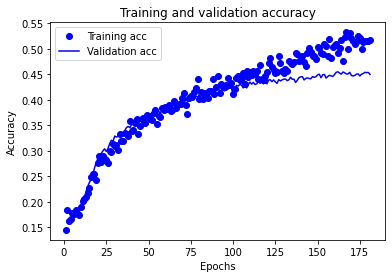

In [ ]:
# EVALUATE YOUR TRAINED MODEL HERE
# plot training vs. validation accuracy

plt.clf()
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Generate Kaggle Submission
Student Requirements:
* Update file paths as appropriate
* Once test data is released, run submission cell to generate and save submission file

In [24]:
# generate test sequences (released via Kaggle ~72 hrs before competition end)
test_sequences = create_test_sequences('/content/drive/My Drive/tweets_test.csv')

Test Corpus Length: 796720 characters.
Total Sequences Generated: 796700.
Test Sequence Array Shape: (796700, 20, 27)
Returning test sequence array.


In [28]:
# make predictions & create submission
#model.save('HW3V2.h5')

path_to_model = '/content/drive/My Drive/HW3V2.h5'
path_to_submissions_folder = '/content/drive/My Drive/'
make_predictions(path_to_model, path_to_submissions_folder, test_sequences)


Loading model from provided path...


Generating & Formatting Predictions...

24897/24897 [==============================] - 273s 11ms/step

Generating Submission...


Saving in provided path as 'submission.csv'...


Done!

